In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import sklearn.metrics as metrics
import matplotlib.gridspec as gridspec
import random
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [2]:
train = pd.read_csv("../input/emnist/emnist-byclass-train.csv",delimiter = ',')
test = pd.read_csv("../input/emnist/emnist-byclass-test.csv", delimiter = ',')
mapp = pd.read_csv("../input/emnist/emnist-byclass-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (697931, 785), Test: (116322, 785), Map: (62,)


In [3]:
# Constants
HEIGHT = 28
WIDTH = 28

In [4]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [5]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(697931, 784) (697931,) (116322, 784) (116322,)


In [6]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

## Augment Data set

In [7]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
# train_x_aug = np.concatenate([train_x,train_x_aug], axis=0)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (697931, 28, 28)
test_x: (116322, 28, 28)




# X_trn = np.copy(X_train)
############################### AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC

dataGen= ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1, \
                            rotation_range=10)
dataGen.fit(train_x)
batches= dataGen.flow(train_x,train_y,batch_size=697931)  
train_x_batch,train_y_batch = next(batches)

train_x_aug = np.concatenate([train_x,train_x_batch], axis=0)
train_y_aug = np.concatenate([train_y,train_y_batch], axis=0)

# print(batches.astype)
print("Augumented Data=",train_x_batch.shape)
print("orignal train set=",train_x.shape)
print("Combined train set=",train_x_aug.shape)

In [8]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255

## Visualize the data****

In [9]:
n_classes = 62
def distributionFunc(annotationSet):
    dSampleCount = []
    samplecount = 0
    for classid in range(n_classes):
        for element in annotationSet:
            if element == classid:
                samplecount = samplecount + 1
        dSampleCount.append(samplecount)
        samplecount = 0
    return (dSampleCount)

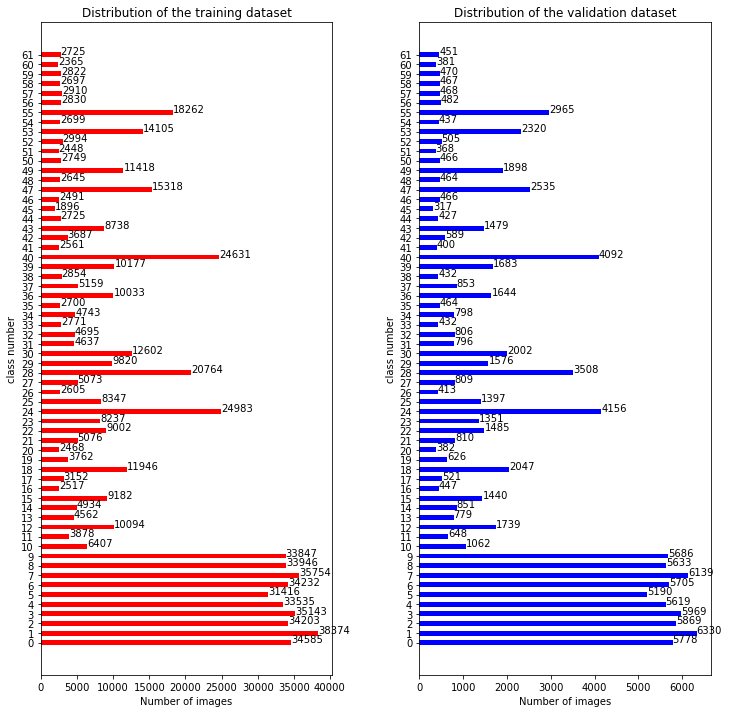

Train Sample count =  697931
Test Sample count =  116322


In [10]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.3, hspace=0.2)
width = 0.5
ax1 = plt.subplot(gs[0])
ax1.set_title("Distribution of the training dataset")
ax1.barh(range(0, n_classes), distributionFunc(train_y), width, align='center', color='red')
ax1.set_yticks(np.arange(0, n_classes, 1))
ax1.set_xlabel("Number of images")
ax1.set_ylabel("class number")
for index, value in enumerate(distributionFunc(train_y)):
    ax1.text(value, index, str(value))
    
ax2 = plt.subplot(gs[1])
ax2.set_title("Distribution of the validation dataset")
ax2.barh(range(0, n_classes), distributionFunc(test_y), width, align='center', color='blue')
ax2.set_yticks(np.arange(0, n_classes, 1))
ax2.set_xlabel("Number of images")
ax2.set_ylabel("class number")
for index, value in enumerate(distributionFunc(test_y)):
    ax2.text(value, index, str(value))
      
plt.show()

print ("Train Sample count = ",np.sum(distributionFunc(train_y)))
print ("Test Sample count = ",np.sum(distributionFunc(test_y)))

In [11]:

def findindex(classid,y_):
    index = 0
    y_index = []
    for value in y_:
        if classid == value:
            y_index.append(index)
        index = index + 1
    return (y_index)
def plotdataSet(dataset,y_class):
    cols = 3
    fig, axs = plt.subplots(n_classes, cols, figsize=(15, 50))   
    fig.tight_layout()  
    for rows in range(n_classes):
        datasetindex = random.sample(findindex(rows,y_class), 3)
        for indx in range(len(datasetindex)):
            axs[rows][indx].set_title(chr(mapp[train_y[datasetindex[indx]]]))
            axs[rows][indx].imshow(dataset[datasetindex[indx]].squeeze())
            axs[rows][indx].axis("off")

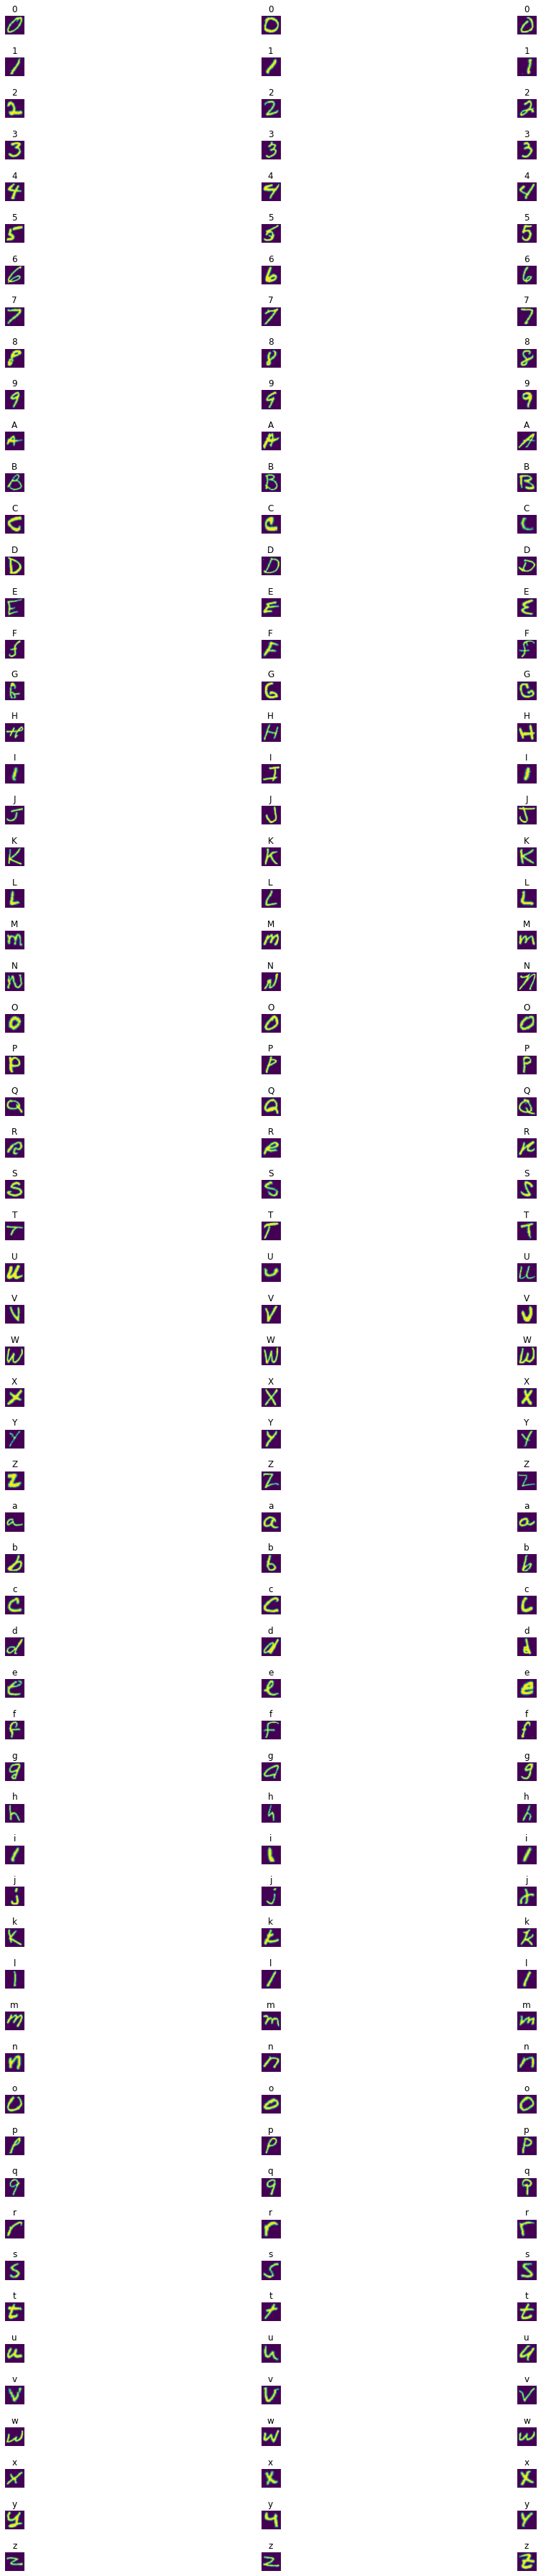

In [12]:
plotdataSet(train_x,train_y)

In [13]:
# number of classes
num_classes = train_y.nunique()

In [14]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (697931, 62)
test_y:  (116322, 62)


In [15]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [16]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)
batch_size = 128
epochs = 15
filename = 'EMNIST.h5'

In [17]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(train_x, train_y, epochs=10, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

Epoch 1/10
1227/1227 [==============================] - 1297s 1s/step - loss: 0.8307 - accuracy: 0.7523 - val_loss: 0.4367 - val_accuracy: 0.8454
Epoch 2/10
1227/1227 [==============================] - 1268s 1s/step - loss: 0.5254 - accuracy: 0.8237 - val_loss: 0.4024 - val_accuracy: 0.8538
Epoch 3/10
1227/1227 [==============================] - 1264s 1s/step - loss: 0.4823 - accuracy: 0.8355 - val_loss: 0.3897 - val_accuracy: 0.8586
Epoch 4/10
1227/1227 [==============================] - 1263s 1s/step - loss: 0.4598 - accuracy: 0.8418 - val_loss: 0.3812 - val_accuracy: 0.8601
Epoch 5/10
1227/1227 [==============================] - 1274s 1s/step - loss: 0.4439 - accuracy: 0.8461 - val_loss: 0.3713 - val_accuracy: 0.8648
Epoch 6/10
1227/1227 [==============================] - 1273s 1s/step - loss: 0.4326 - accuracy: 0.8486 - val_loss: 0.3718 - val_accuracy: 0.8639
Epoch 7/10
1227/1227 [==============================] - 1269s 1s/step - loss: 0.4243 - accuracy: 0.8504 - val_loss: 0.3671 -

In [20]:
model.save(filename)
#newmodel = load_model(filename)

In [21]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [22]:
#%%
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

KeyError: 'acc'

In [23]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

NameError: name 'acc' is not defined

In [24]:
# loss curve
plotgraph(epochs, loss, val_loss)

NameError: name 'loss' is not defined

In [ ]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

In [ ]:
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))